# Introduction

This notebook contains the code and experiments needed to build the Figure 2 of our paper "__Weighted Metamorphosis for registration of images with different topologies__". In addition you will find at the end of each part a gif of the image evolution along with the deformation grid.
In the Figure 2, there is two set of experiments on two different MRI slices. You can see the other one by uncommenting the line 23 of first cell.

device used : cuda:0
BraTS2021_00090_seg.png


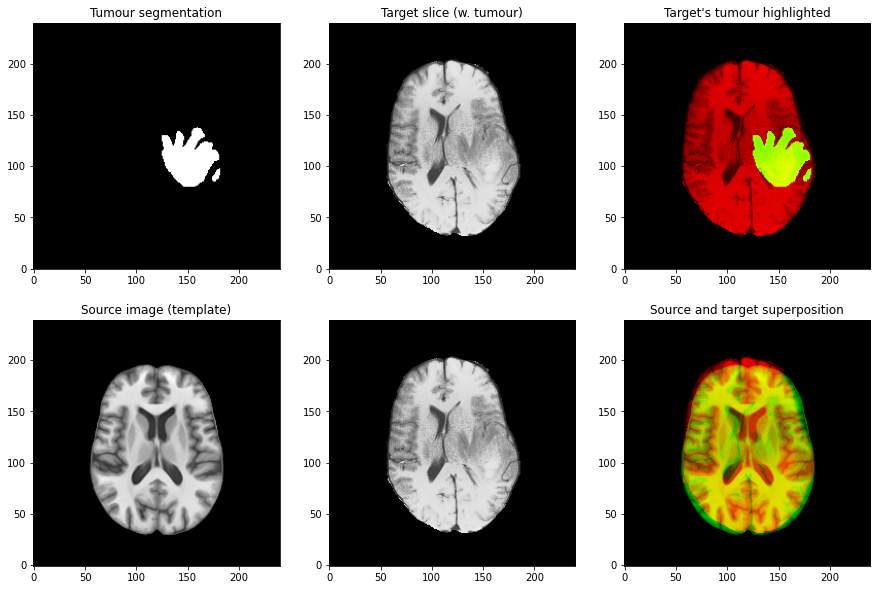

In [3]:
import matplotlib.pyplot as plt
import torch
import time
# import my_torchbox as tb
from my_toolbox import format_time,rgb2gray
from constants import DLT_KW_IMAGE as kws
from constants import ROOT_DIRECTORY

# %load_ext autoreload
# %autoreload 2
import metamorphosis as mt
import my_torchbox as tb

cuda = torch.cuda.is_available()
device = 'cpu'
if cuda:
    device = 'cuda:0'
torch.autograd.set_detect_anomaly(False)
print('device used :',device)


path = ROOT_DIRECTORY+ '/im2Dbank/'
source_name = "sri24_template.png"
target_name = "BraTS2021_00090_80_.png"
# target_name = "BraTS2021_00147_80_.png"  # To see the other brain presented in the paper, uncomment this line.
seg_name = target_name[:16]+'seg.png'
print(seg_name)
source = torch.tensor(rgb2gray(plt.imread(path+source_name)),dtype=torch.float)[None,None]
target = torch.tensor(rgb2gray(plt.imread(path+target_name)),dtype=torch.float)[None,None]
segmentation = torch.tensor(rgb2gray(plt.imread(path+seg_name)),dtype=torch.float)[None,None]
#print(source.shape,target.shape,segmentation.shape)

plt.rcParams["figure.figsize"] = (15,10)
fig,ax = plt.subplots(2,3)
ax[0,0].imshow(segmentation[0,0].cpu().numpy(),**kws)
ax[0,0].set_title('Tumour segmentation')
ax[0,1].imshow(target[0,0,:,:].cpu().numpy(),**kws)
ax[0,1].set_title('Target slice (w. tumour)')
ax[0,2].imshow(tb.imCmp(segmentation,target),**kws)
ax[0,2].set_title("Target's tumour highlighted")
ax[1,0].imshow(source[0,0].cpu().numpy(),**kws)
ax[1,0].set_title('Source image (template)')
ax[1,1].imshow(target[0,0,:,:].cpu().numpy(),**kws)
ax[1,2].imshow(tb.imCmp(source,target),**kws)
ax[1,2].set_title('Source and target superposition')
plt.show()

# 0./ How to read the plots
For each Experiments successives plots are showed :
 1. __Cost evolution__
    1. With relative coefficients, (i.e.: we plot $\rho \|z_0\|_{L^2}^2$)
    2. Raw values (i.e.: we plot $\|z_0\|_{L_2}^2$)
 2. __Visualisation of the method end product__. We compare the image at the end of the geodesic ($I_1$) with source and target images
 3. __Geodesic evolution visualisation__. Each row represent a given time point, The first collumn is the image evolution ($I_t$), the second show the residuals ($z_t$) and the third the deformation generated by the field $v_t$.
 4. __Deformation visualisation.__ In this series of plot we show the quality of the end deformation $\Phi = \int_0^1 v_t dt; v_0 = Id$
     1. Deformation grid of $\Phi$
     2. Quiver plot of $\Phi$
     3. (4 images) Comparison of the image deformed by $\Phi$ with the source and target images.


# 1./ Classical methods : LDDMM and Metamorphosis

Before demonstrating the Weighted Metamorphosis results, lets show how LDDMM and the classical Methamorphosis behave on this toy examples.

## 1.a. LDDMM

We solve the cost:
$$H(z_0) =   \frac 12\| I_{1} - T \|_{L_2}^2 + \lambda  \|v_0\|^2_V $$
with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right>
\end{array}
\right.
$$

Progress: [##########] 100.00% Done...val ,  262.48).
 (cost_val ,  262.42).
Computation done in  0:02:51s and 0.414cents  s


(<Figure size 1080x1800 with 25 Axes>,
 array([[<AxesSubplot:title={'center':'t = 0.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.2'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.5'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.7'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 1.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>]],
       dtype=object))

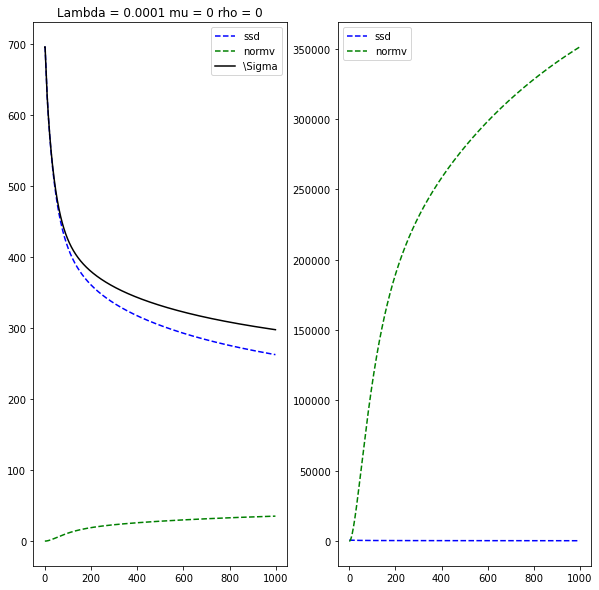

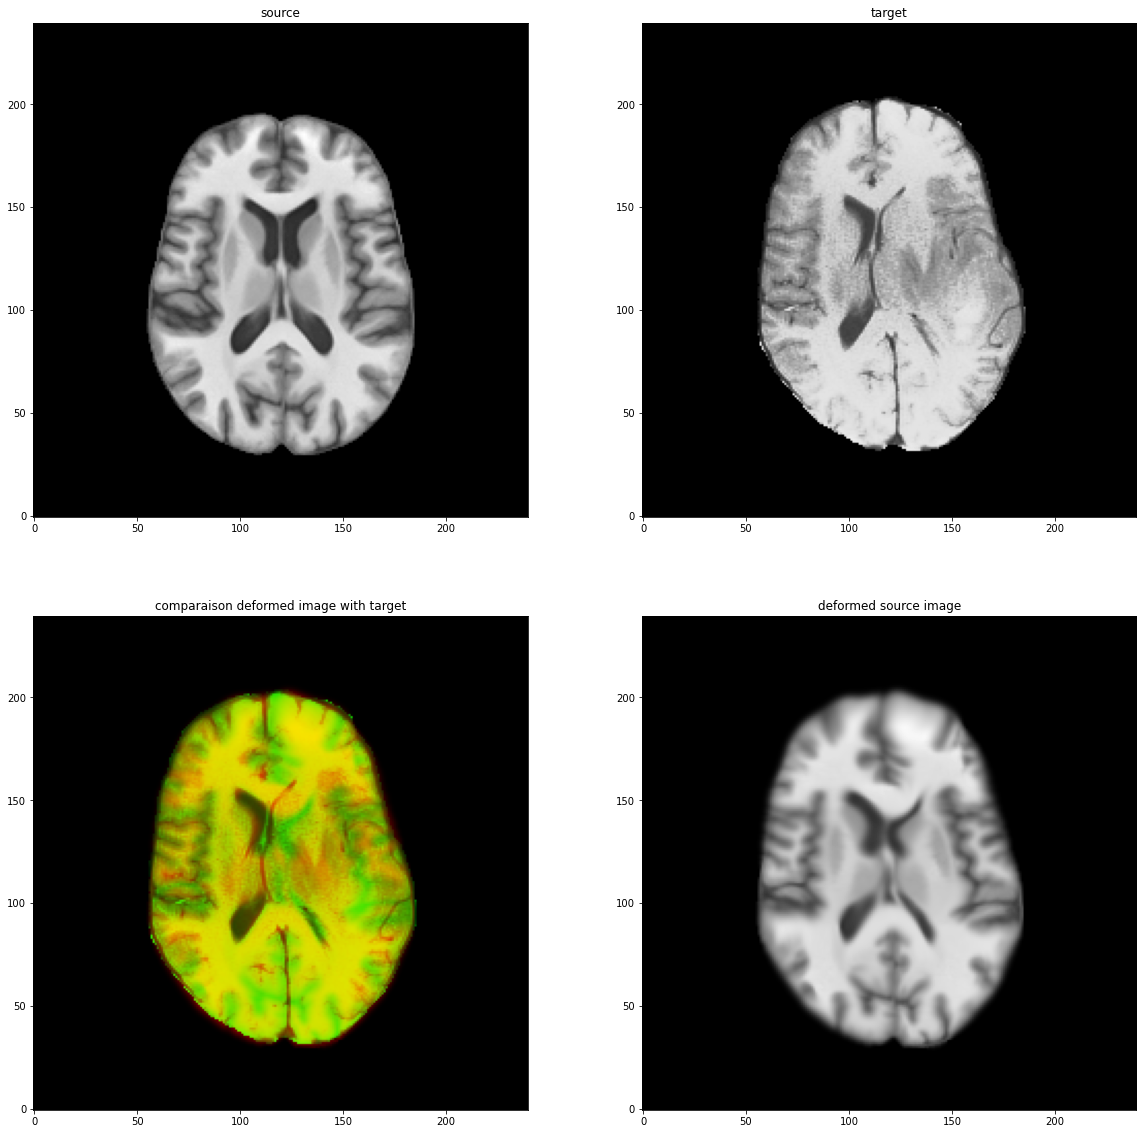

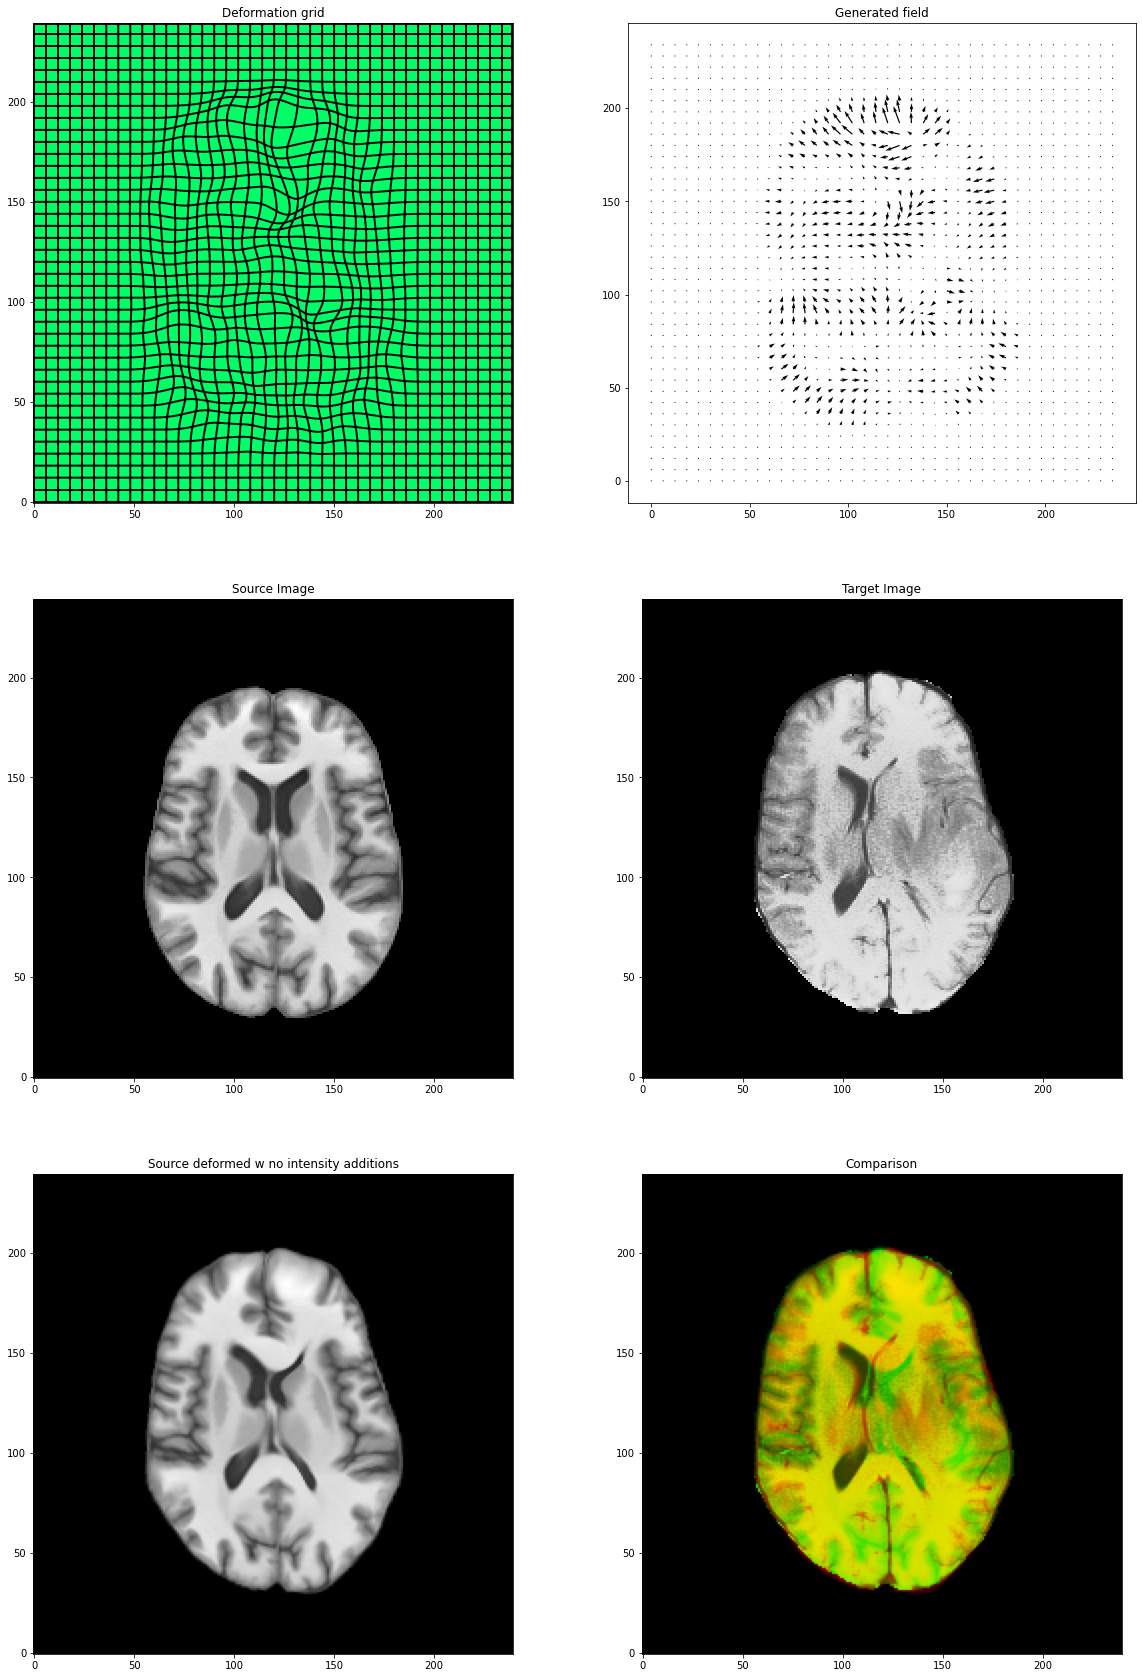

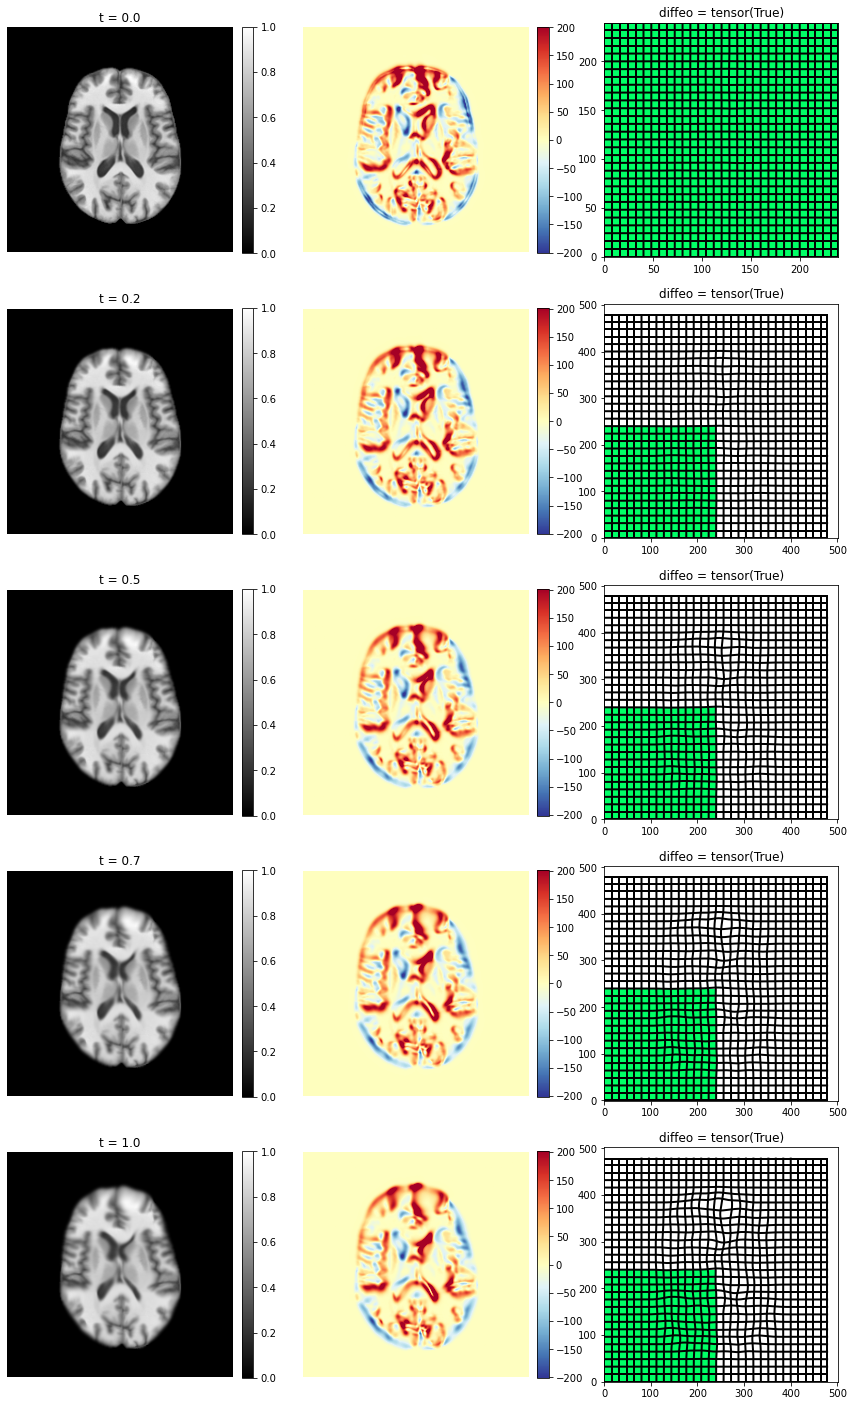

In [5]:
sigma,cost_cst = (6,.0001)
integration_step,n_iter,grad_coef = (20,1000,1000)
residuals = torch.zeros(source.shape[2:],device = device)
start = time.time()
mr_lddmm = mt.lddmm(source,target,residuals,sigma,cost_cst,
                    integration_step,n_iter,grad_coef,
                    safe_mode=False)
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr_lddmm.plot()
mr_lddmm.plot_deform()
mr_lddmm.mp.plot()

<img src="gifs/brains_WBIR_BraTS2021_00090_LDDMM.gif" width="750" align="center">

## 1.b Metamorphosis

We optimise with the cost:
$$H(z_0) =   \frac 12\| I_1 - T \|_{L_2}^2 + \lambda \Big[ \|v_0\|^2_V + \rho \|z_0\|^2_{L_2} \Big]$$

with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - \frac{\rho}{\mu} K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right> + \mu z_t
\end{array}
\right.
$$

Progress: [##########] 100.00% Done...val ,   42.94).
 (cost_val ,   36.82).
Computation done in  0:00:59s and 0.730cents  s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 1080x1800 with 25 Axes>,
 array([[<AxesSubplot:title={'center':'t = 0.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.2'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.5'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 0.7'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>],
        [<AxesSubplot:title={'center':'t = 1.0'}>, <AxesSubplot:>,
         <AxesSubplot:title={'center':'diffeo = tensor(True)'}>]],
       dtype=object))

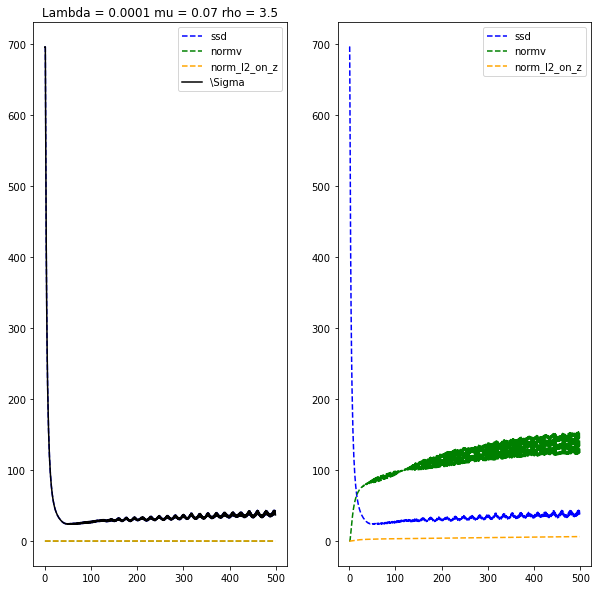

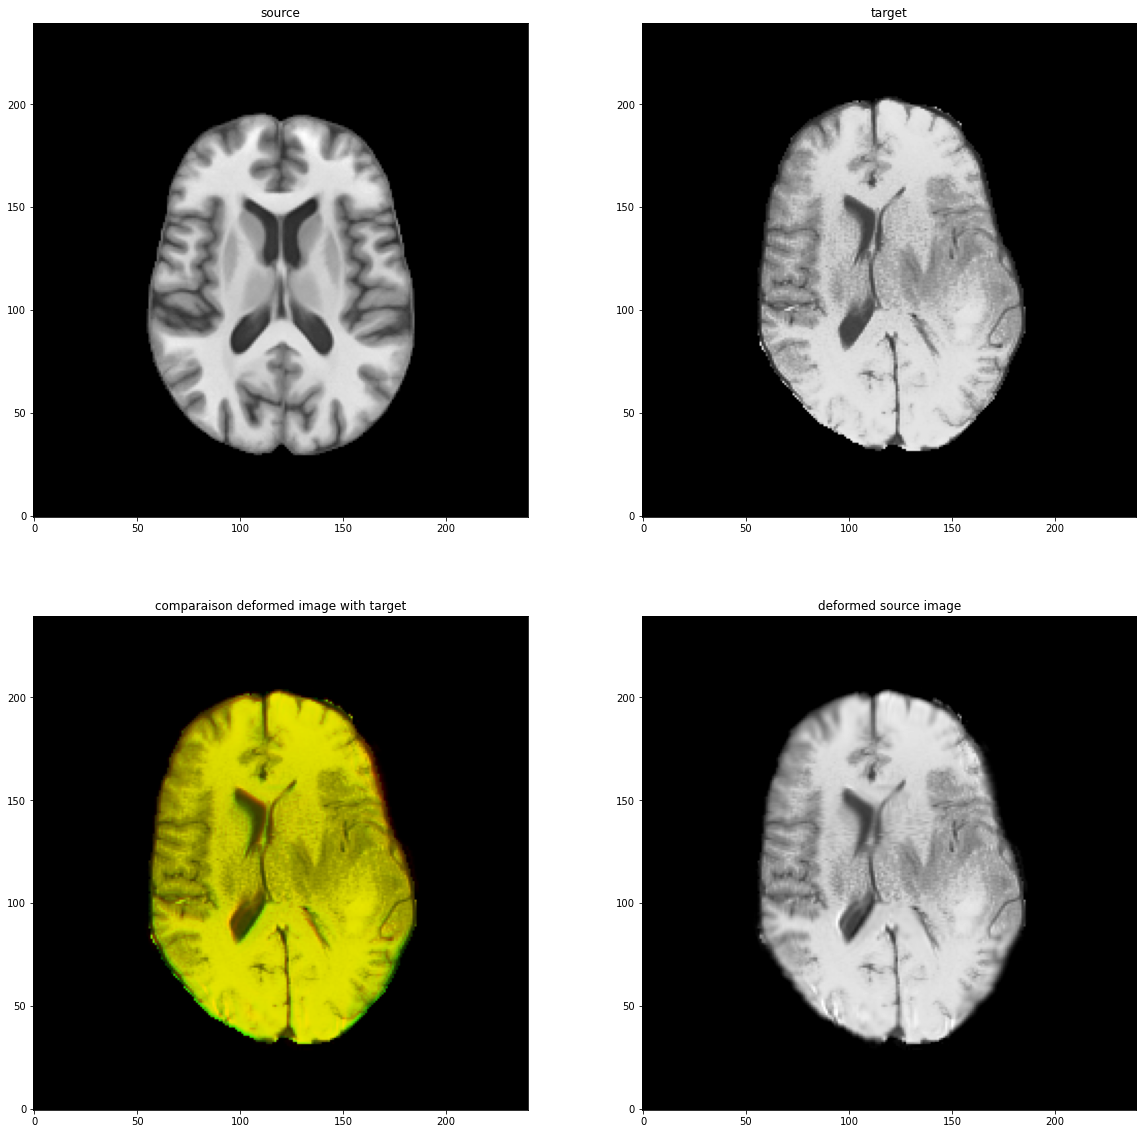

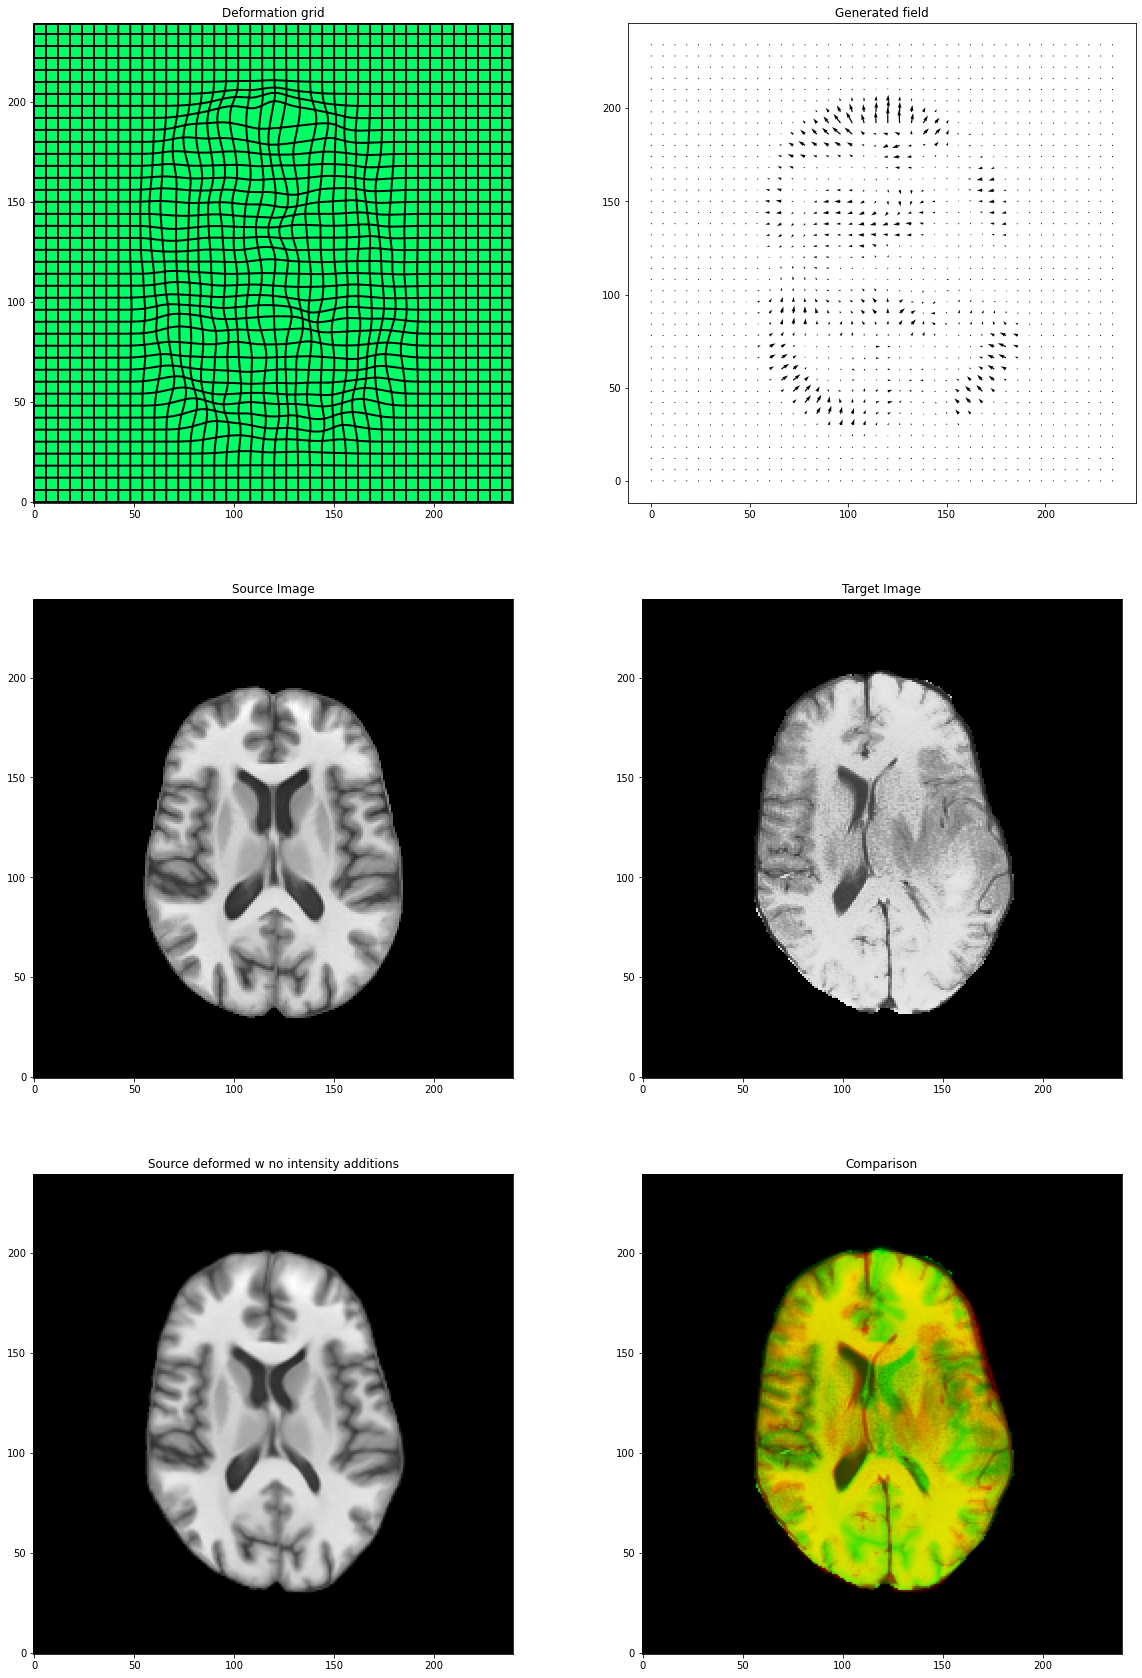

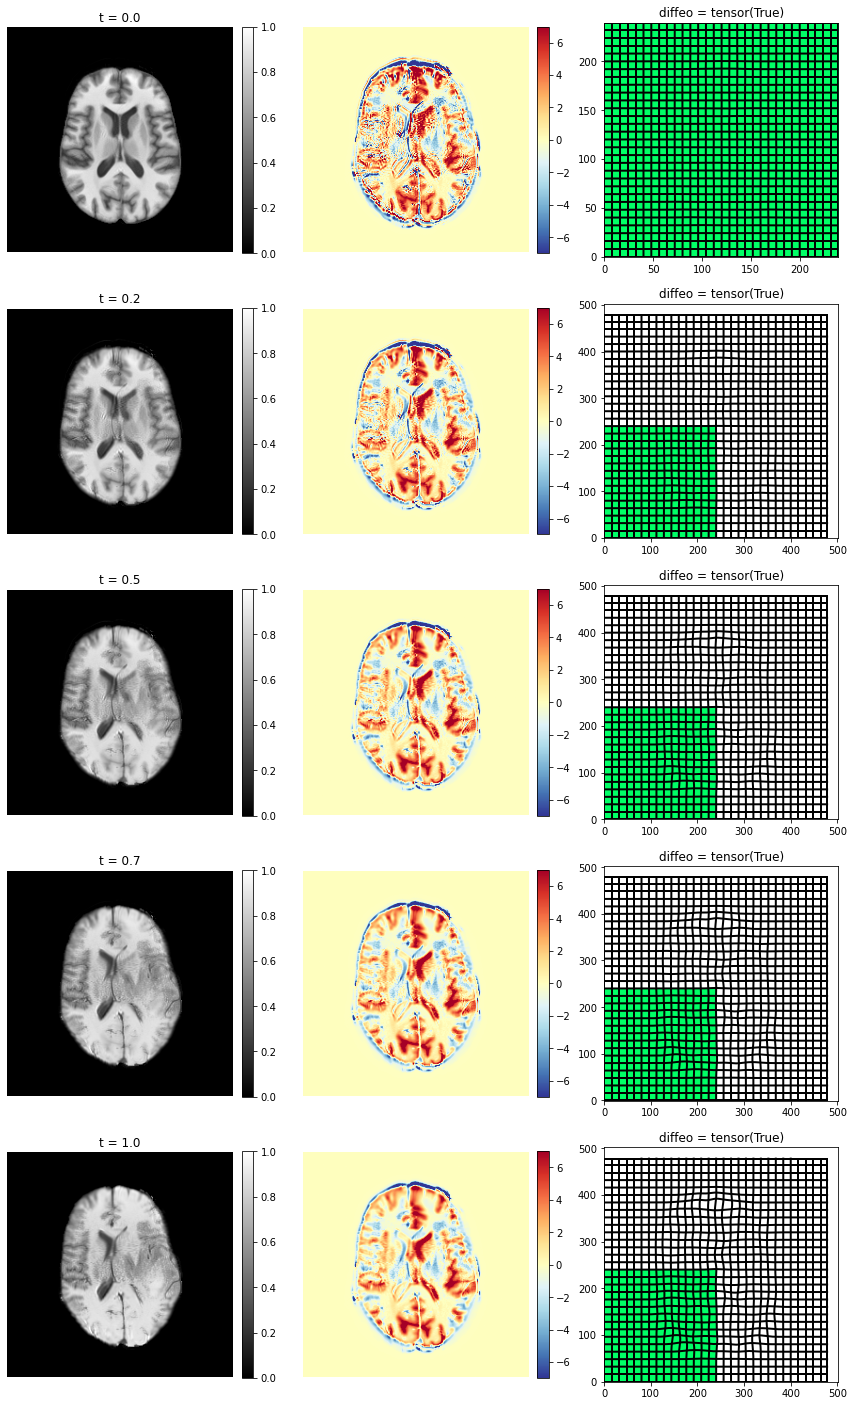

In [6]:
mu,rho,lamb,sigma = (.07,3.5,.0001,6)
integration_step,n_iter,grad_coef = (20,500,100)
residuals = torch.zeros(source.shape[2:],device = device)
start = time.time()
mr_meta = mt.metamorphosis(source,target,residuals,mu,rho,sigma,lamb,
                    integration_step,n_iter,grad_coef,
                    safe_mode=False)
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr_meta.plot()
mr_meta.plot_deform()
mr_meta.mp.plot()

<img src="gifs/brains_WBIR_BraTS2021_00090_meta_3.gif" width="750" align="center">




# 2./ Weighted Metamorphoses.


We solve the cost:
$$H(z_0) =   \frac 12\| I_1 - T \|_{L_2}^2 + \lambda \Big[ \|v_0\|^2_V + \rho \|\sqrt{M_0}z_0\|^2_{L_2} \Big]$$

with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - \frac{\rho}{\mu} K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right> + \mu z_t
\end{array}
\right.
$$

## Mask construction

centre = (tensor(153), tensor(108)), r = 41 and the seg and ball have 129 pixels overlapping
Progress: [##########] 100.00% Done...val ,   71.93).
 (cost_val ,   71.91).
Computation done in  0:01:18s and 0.785cents  s


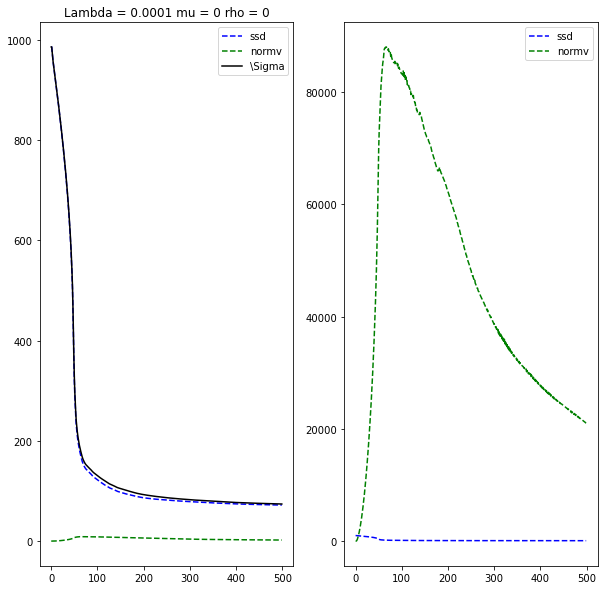

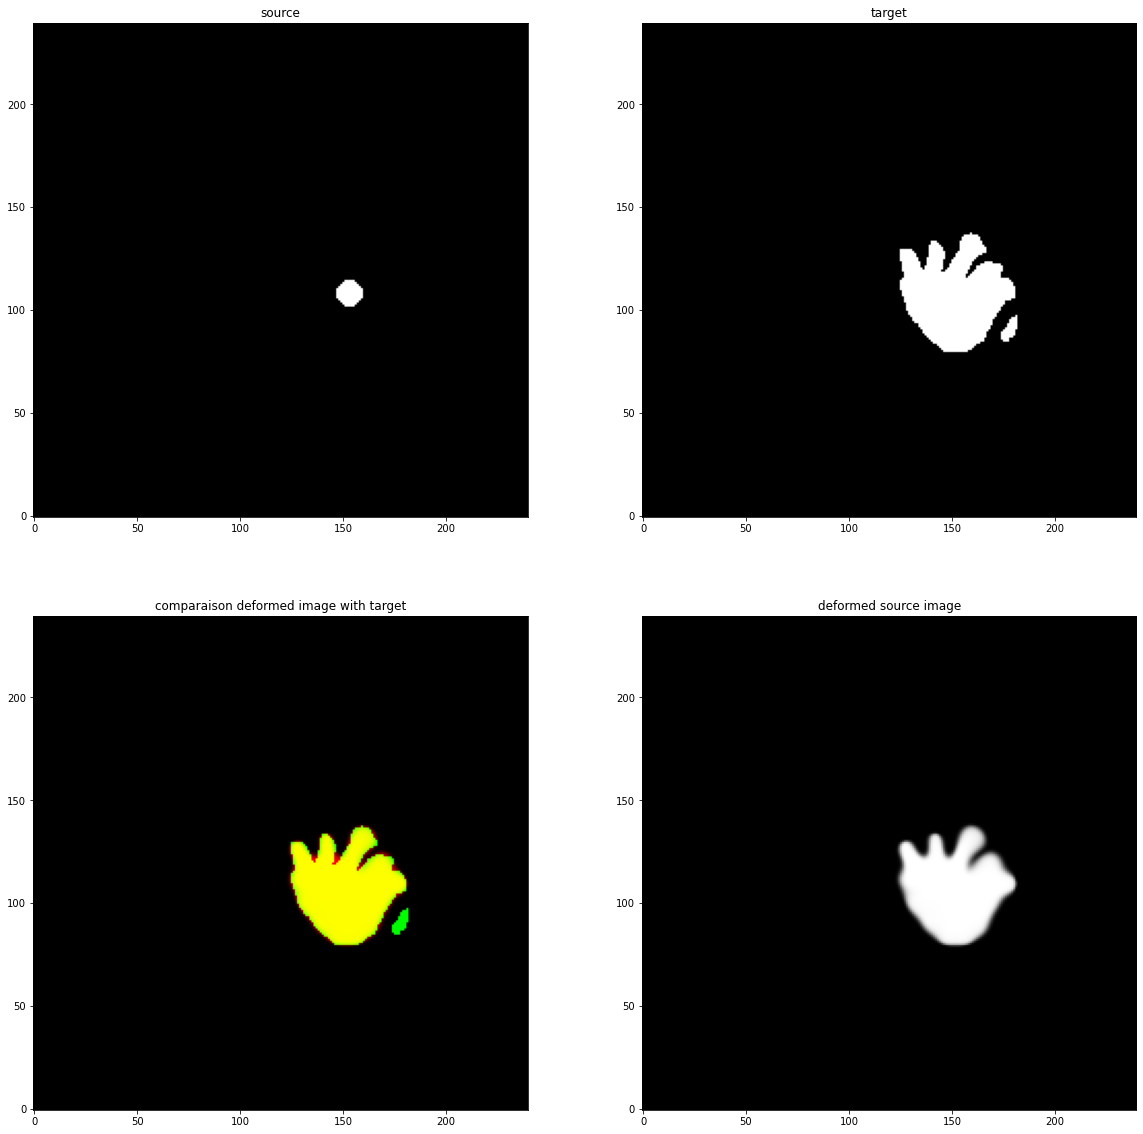

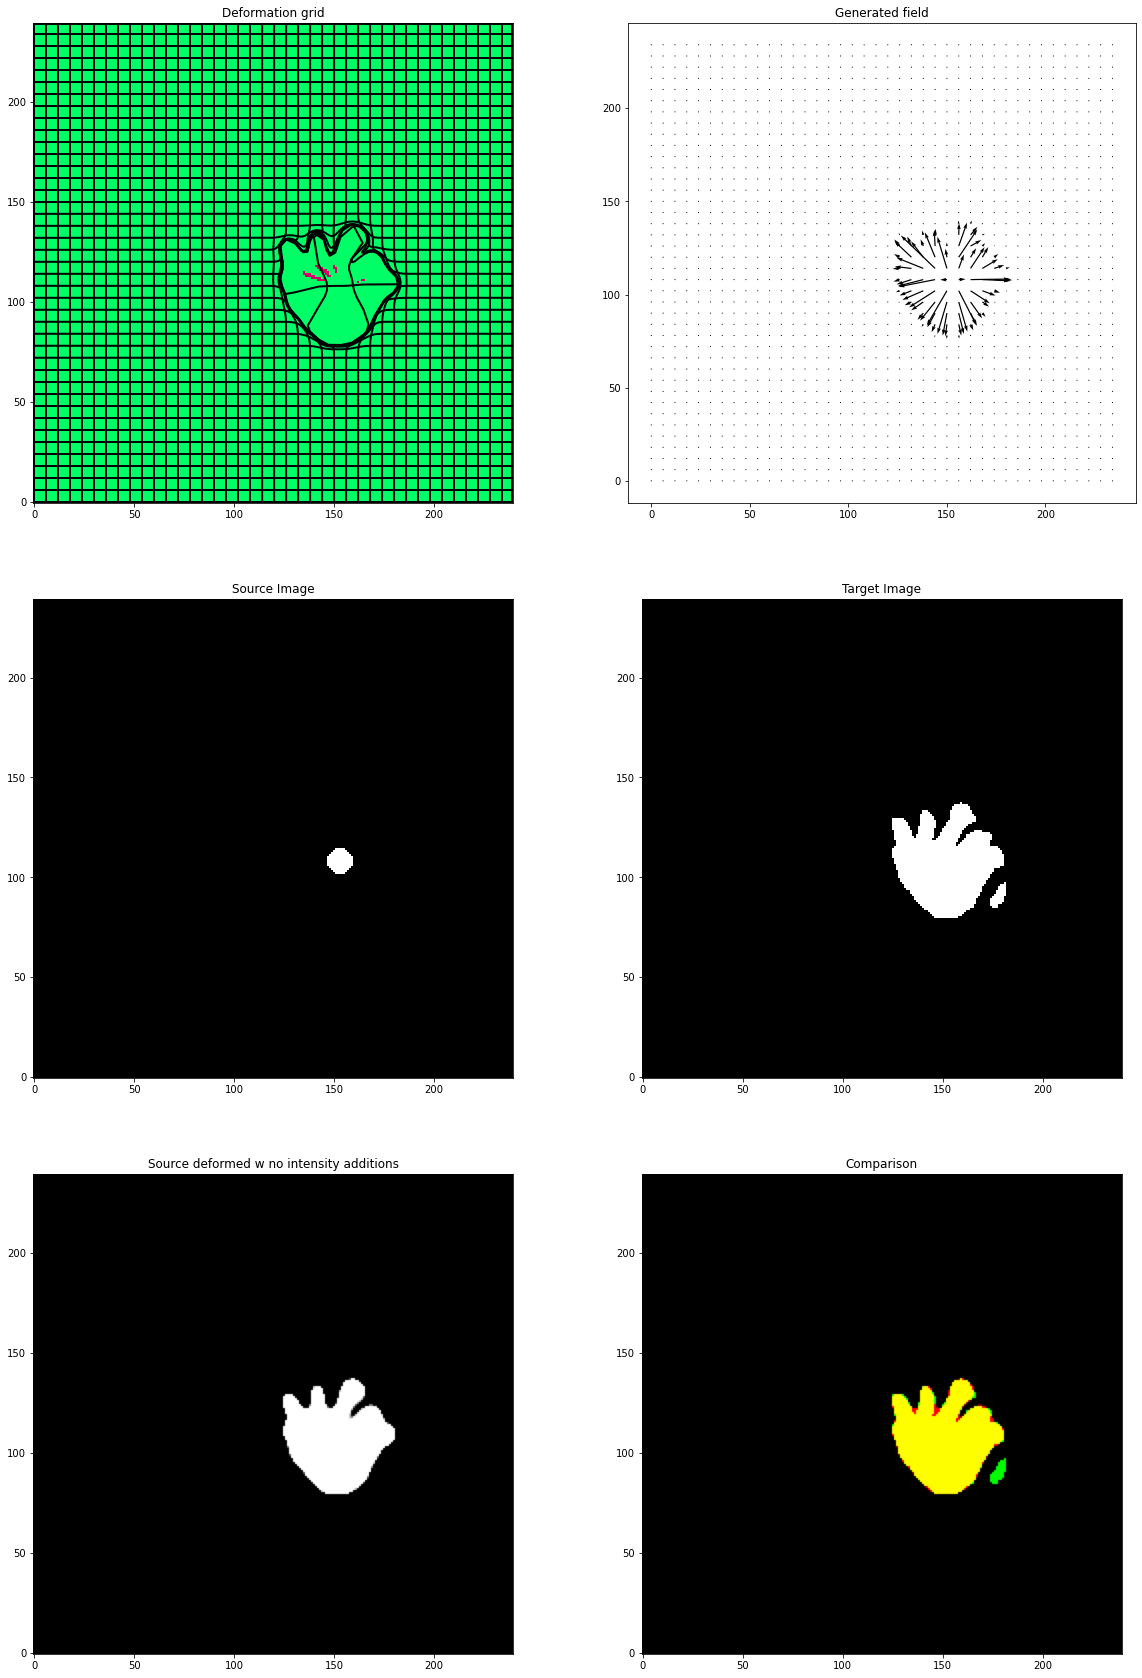

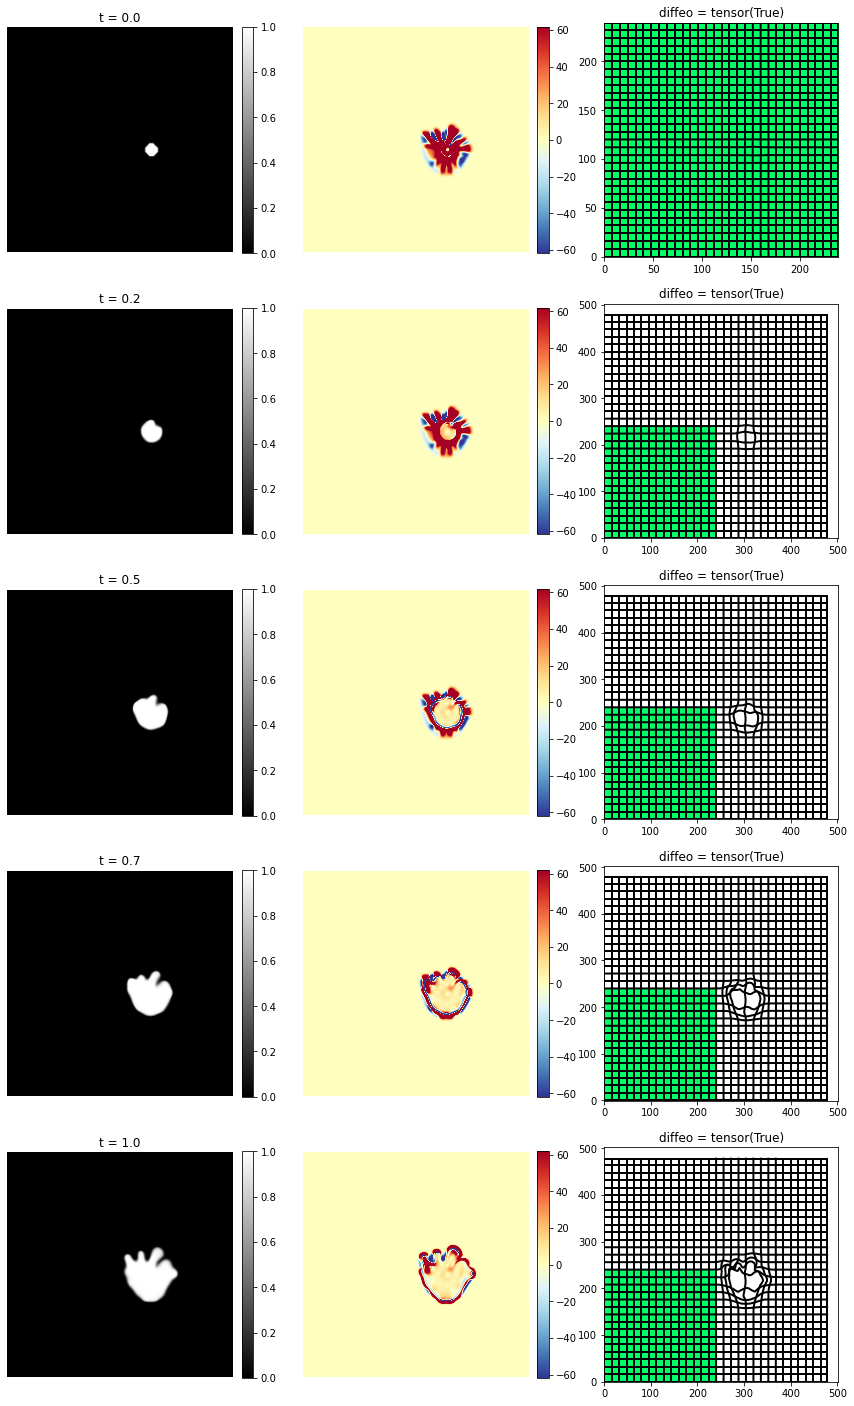

In [10]:
ini_ball,_ = tb.make_ball_at_shape_center(segmentation,overlap_threshold=0.05,verbose=True)

residuals = torch.zeros(source.shape[2:],device = device)
start = time.time()
mr = mt.lddmm(ini_ball,segmentation,residuals,3,.0001,
                    integration_steps=20,n_iter=500,grad_coef=1000,
                    optimizer_method='adadelta',safe_mode=False)
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr.plot()
mr.plot_deform()
mr.mp.plot()
mask = mr.mp.image_stock

## WM computation


Progress: [##########] 100.00% Done...val ,   61.32).
 (cost_val ,   61.28).
Computation done in  0:02:36s and 0.060cents  s


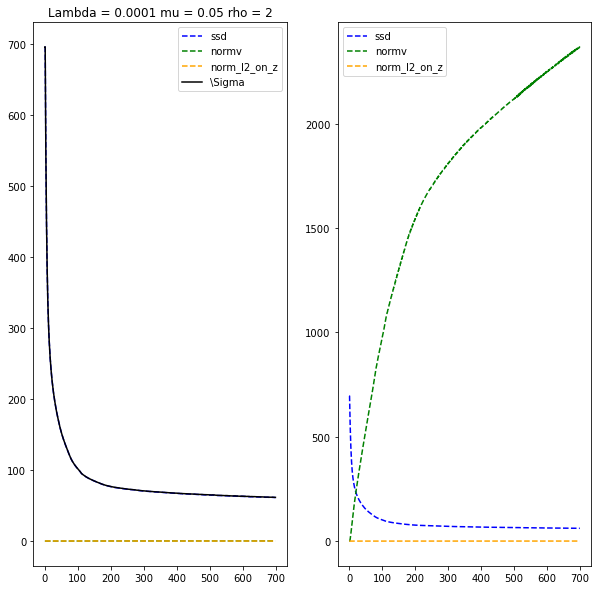

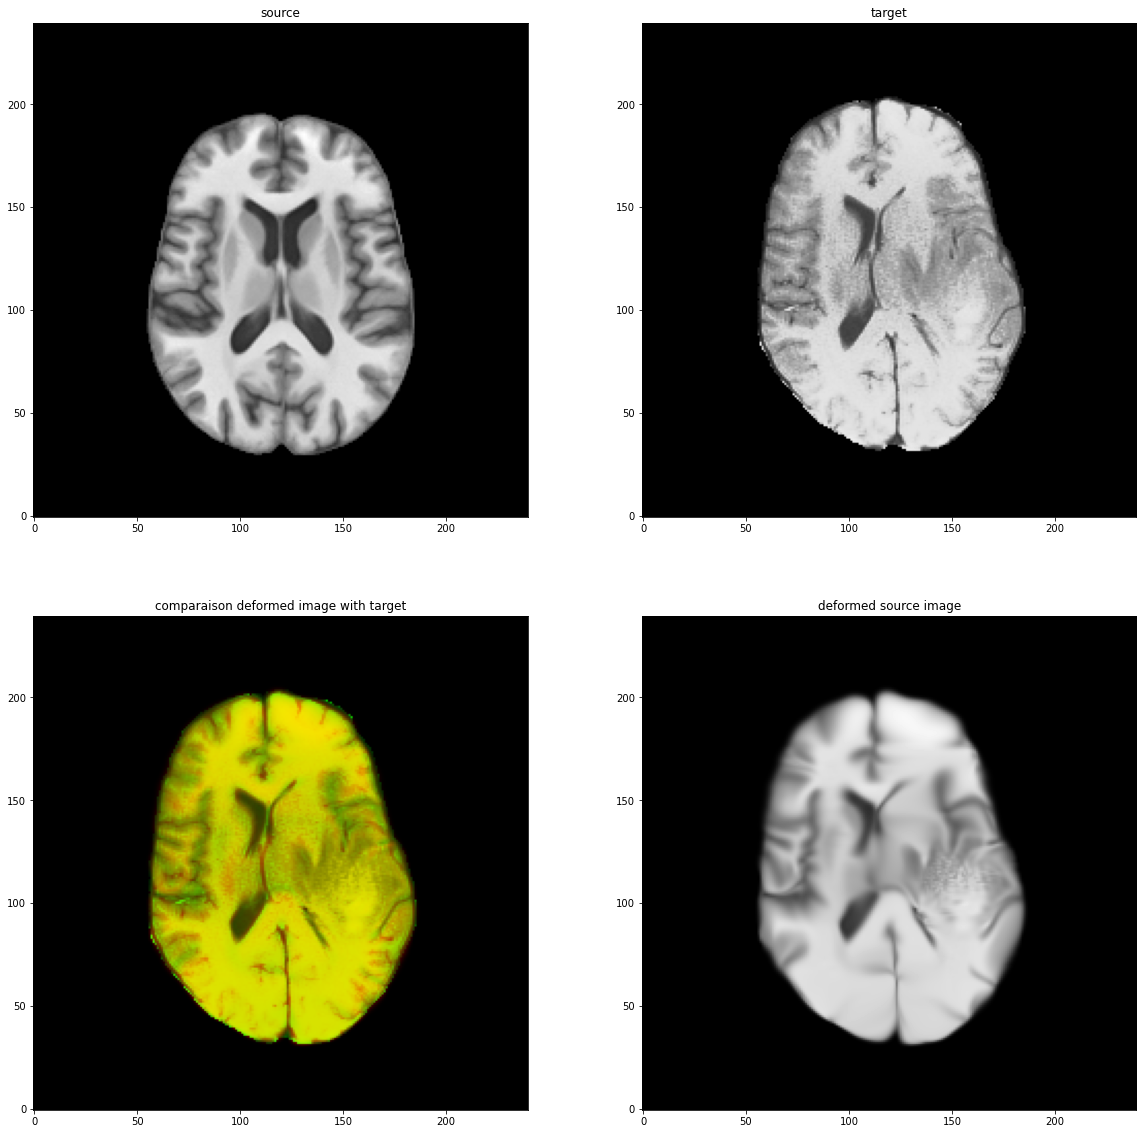

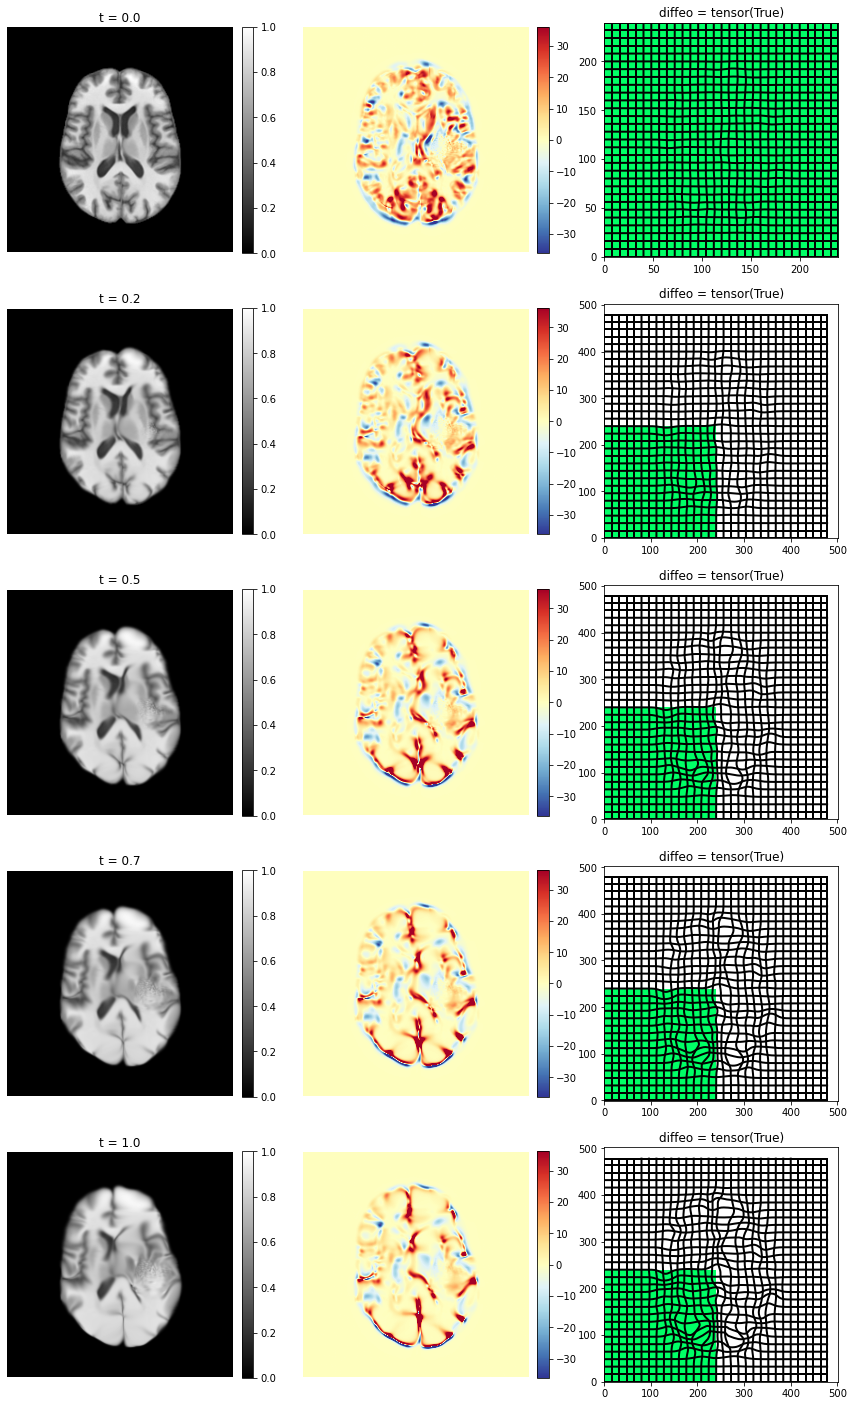

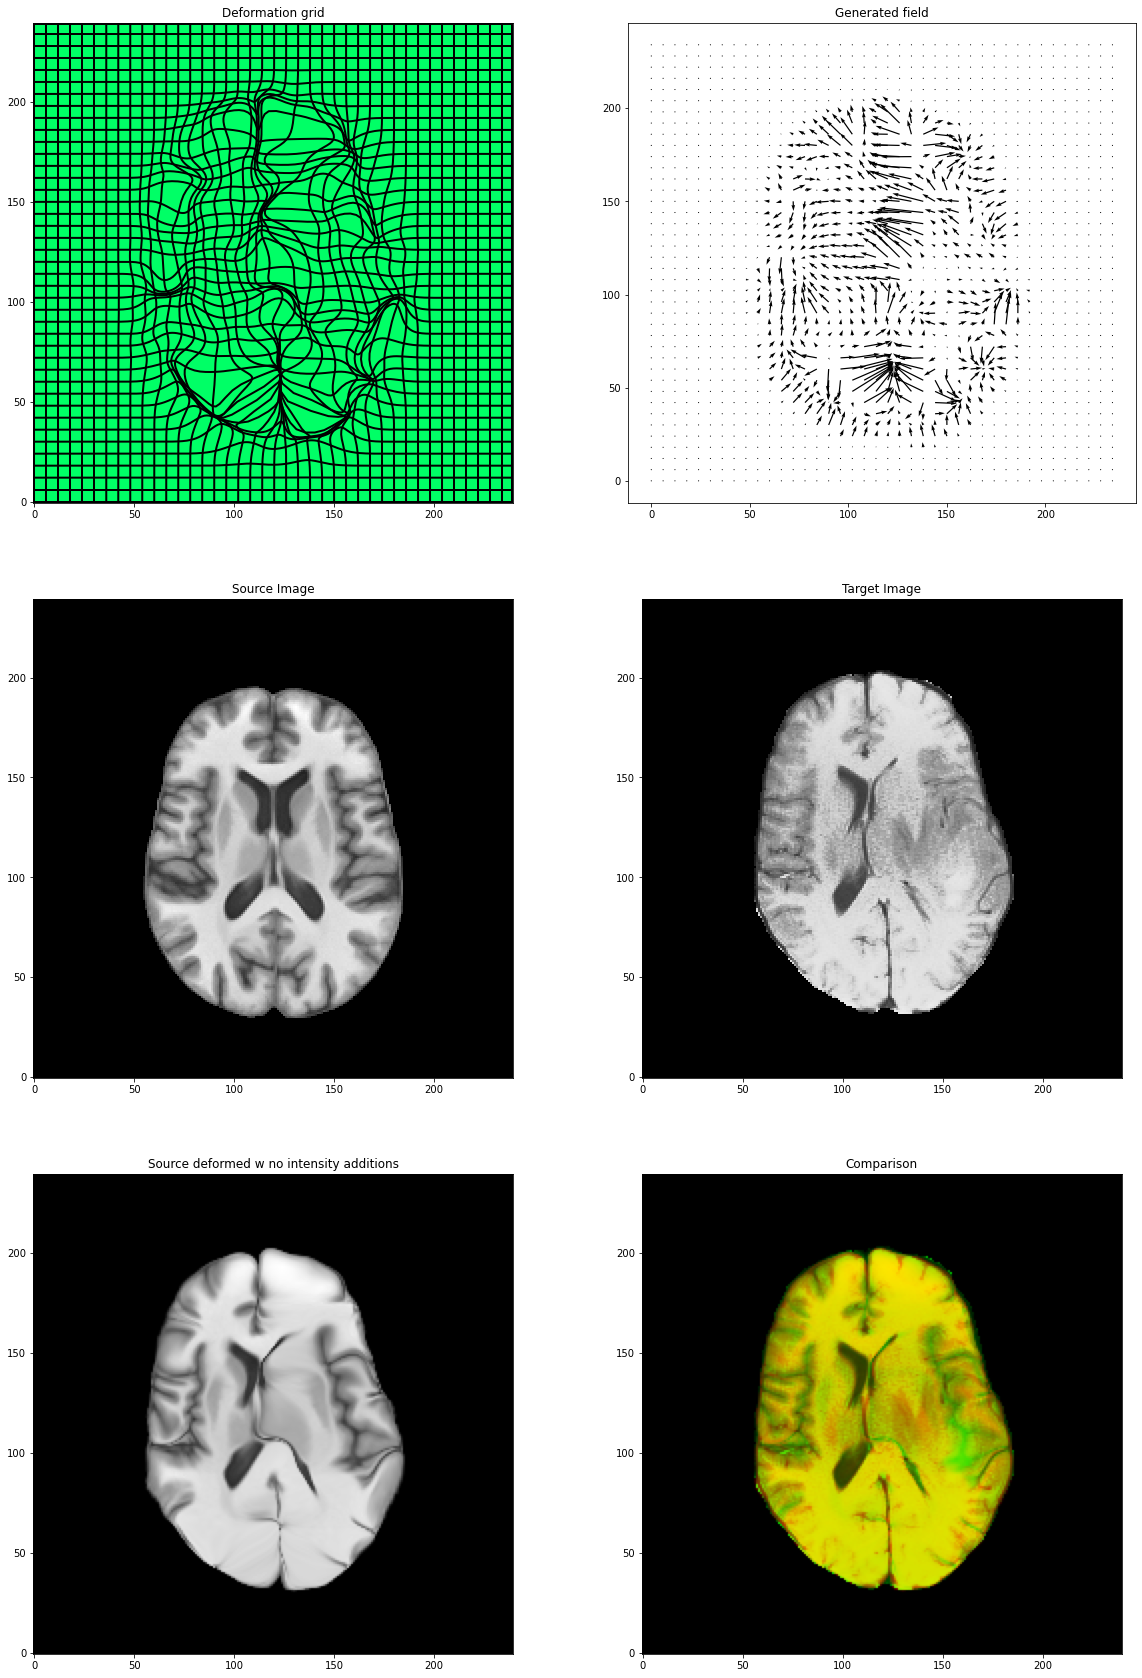

In [11]:
mu,rho,lamb,sigma = (.05,2,.0001,6)
n_iter,grad_coef = (700,100)
residuals = torch.zeros(source.shape[2:],device = device)
start = time.time()
mr_wm = mt.weighted_metamorphosis(source,target,residuals,mask,
                    mu,rho,'identity',sigma,lamb,
                    n_iter,grad_coef,
                    safe_mode=False)

end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr_wm.plot()
mr_wm.mp.plot()
mr_wm.plot_deform()

<img src="gifs/brains_WBIR_BraTS2021_00090_WM_3.gif" width="750" align="center">